This notebook trains a 3D CNN on the ADNI dataset with pytorch.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # adapt plots for retina displays

In [2]:
import os

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

In [4]:
from utils import plot_learning_curve, load_nifti, plot_slices, animate_slices

# General

In [5]:
e = 1e-6  # small perturbation to prevent zero division

# Explore data
This is mainly to figure out what the values of the input data are and which normalization makes sense.

In [50]:
all_struct_arr = np.zeros((10, 91, 109, 91))
for i, filename in enumerate(os.listdir(data_dir)[:10]):
    struct_arr = load_nifti(os.path.join(data_dir, filename), mask=mask)
    all_struct_arr[i] = struct_arr

In [55]:
def normalize(struct_arr):
    # Global normalization (i.e. subtract global mean and divide by global std).
    #return (struct_arr - all_struct_arr.mean()) / (all_struct_arr.std() + e)
    # Voxelwise normalization.
    return (struct_arr - all_struct_arr.mean(0)) / (all_struct_arr.std(0) + e)

In [56]:
which = 2

-0.0 1893.51379395 None None


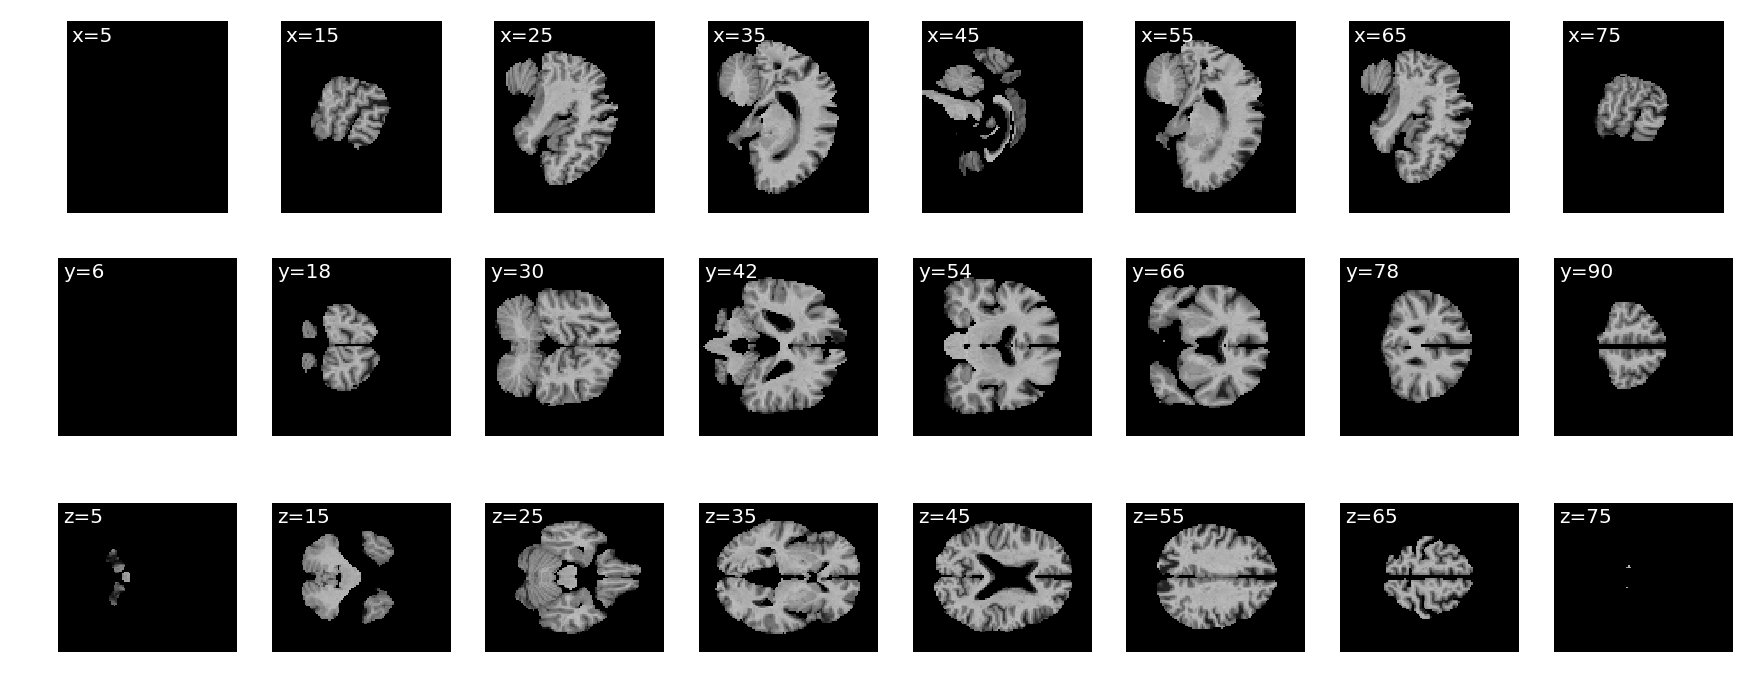

In [57]:
# Without normalization.
plot_slices(all_struct_arr[which])

-1.74211581794 2.9642684715 None None


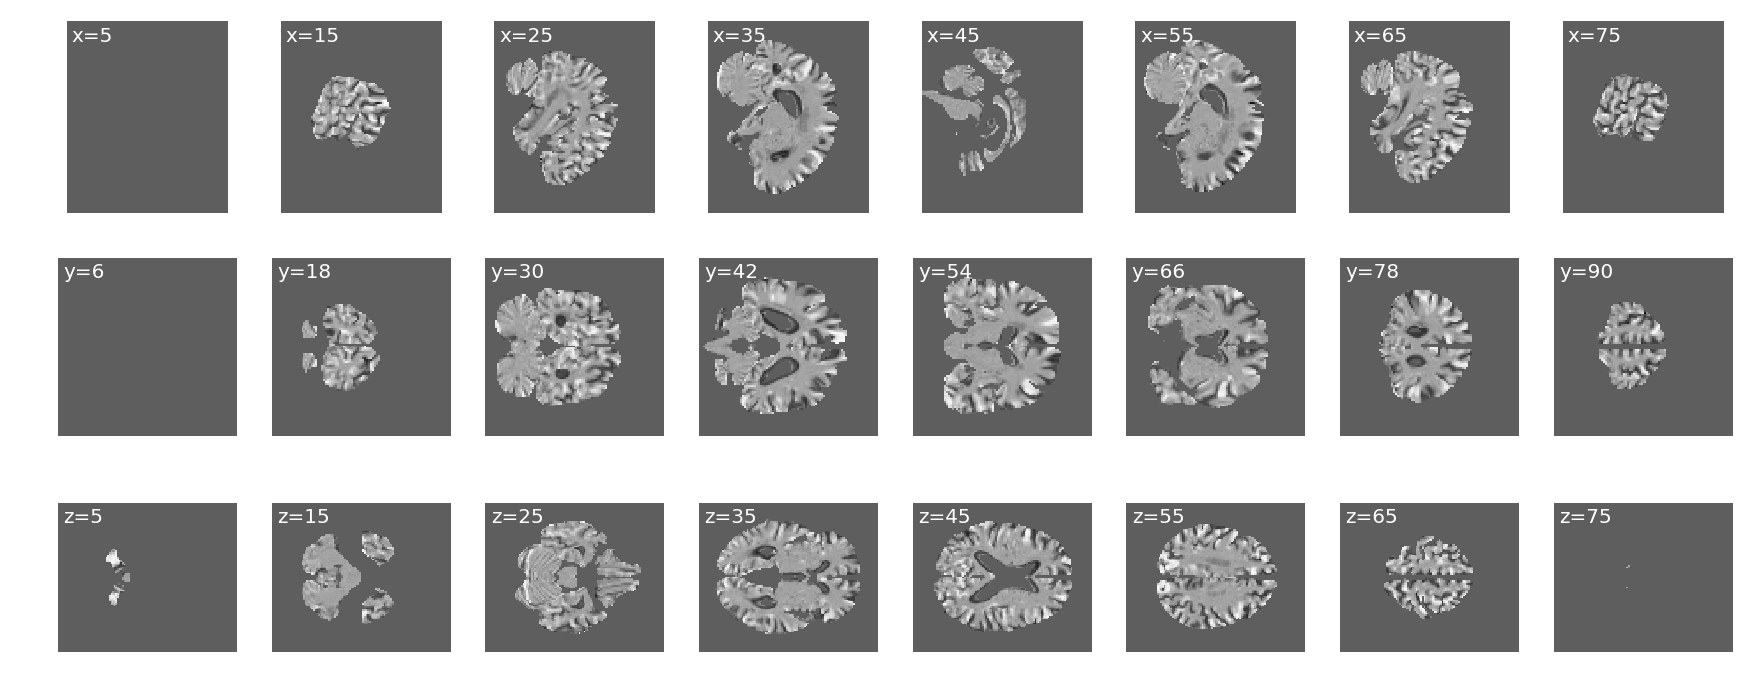

In [101]:
# With normalization.
plot_slices(normalize(all_struct_arr[6]))

0.0 531.285152101 None None


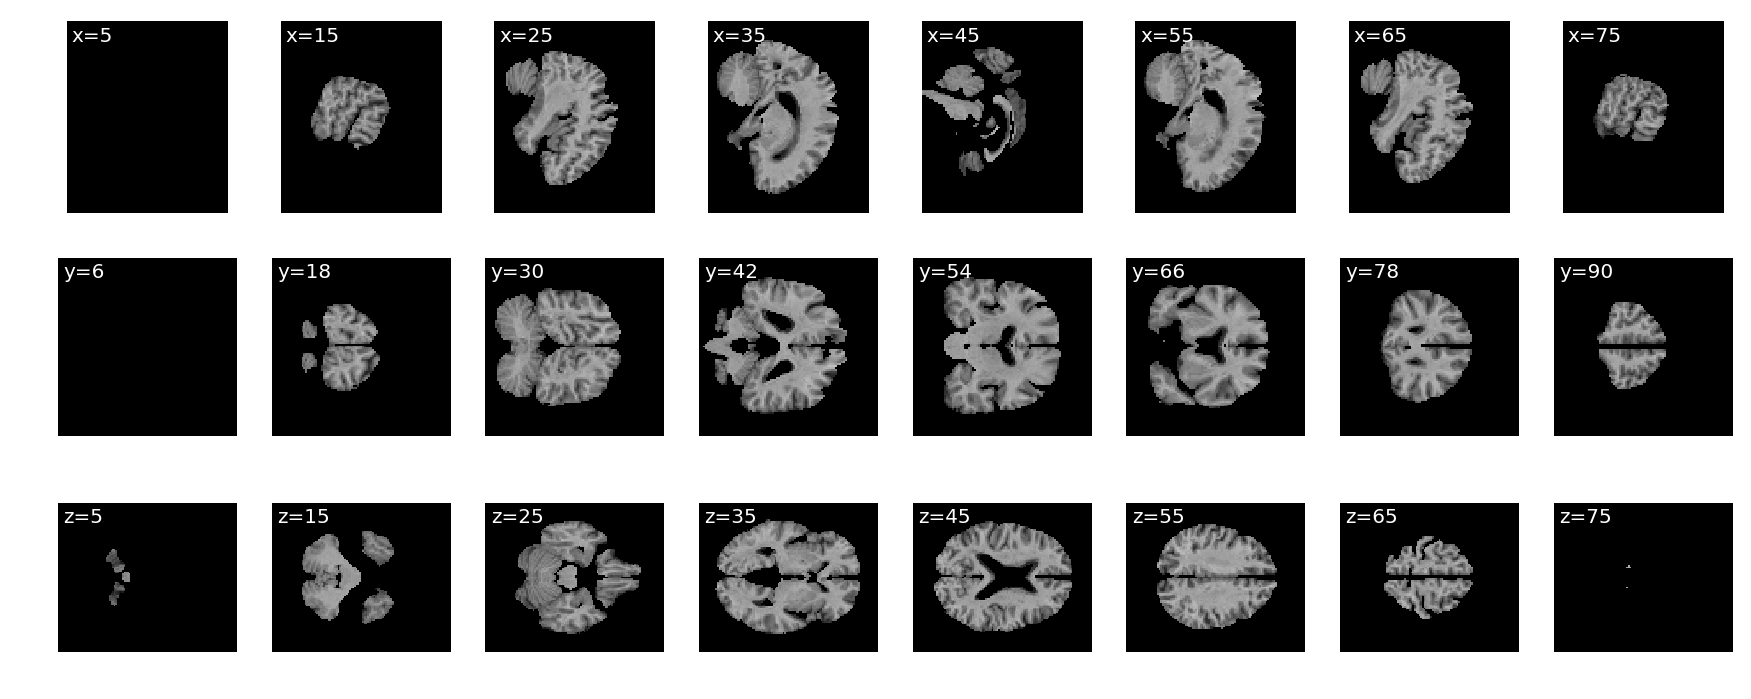

In [62]:
plot_slices(all_struct_arr.std(0))

In [82]:
all_struct_arr.std(0).shape, all_struct_arr.std(0).mean(), val_dataset.std.shape, val_dataset.std.mean()

((91, 109, 91), 55.312238839306545, (91, 109, 91), 35.68255602534866)

0.0 525.784363086 None None


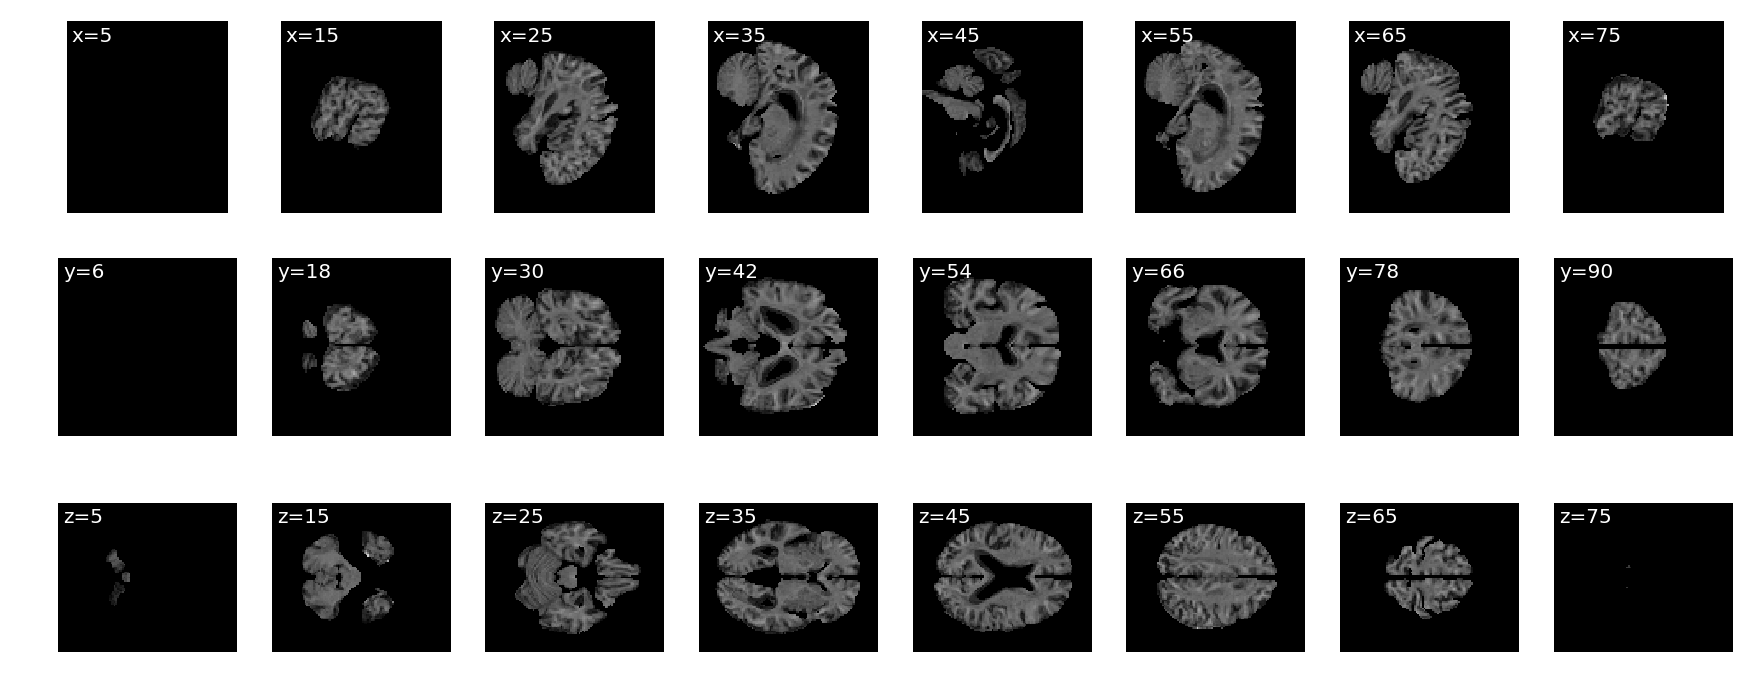

In [80]:
plot_slices(val_dataset.std)

-0.0 19.8802127838 None None


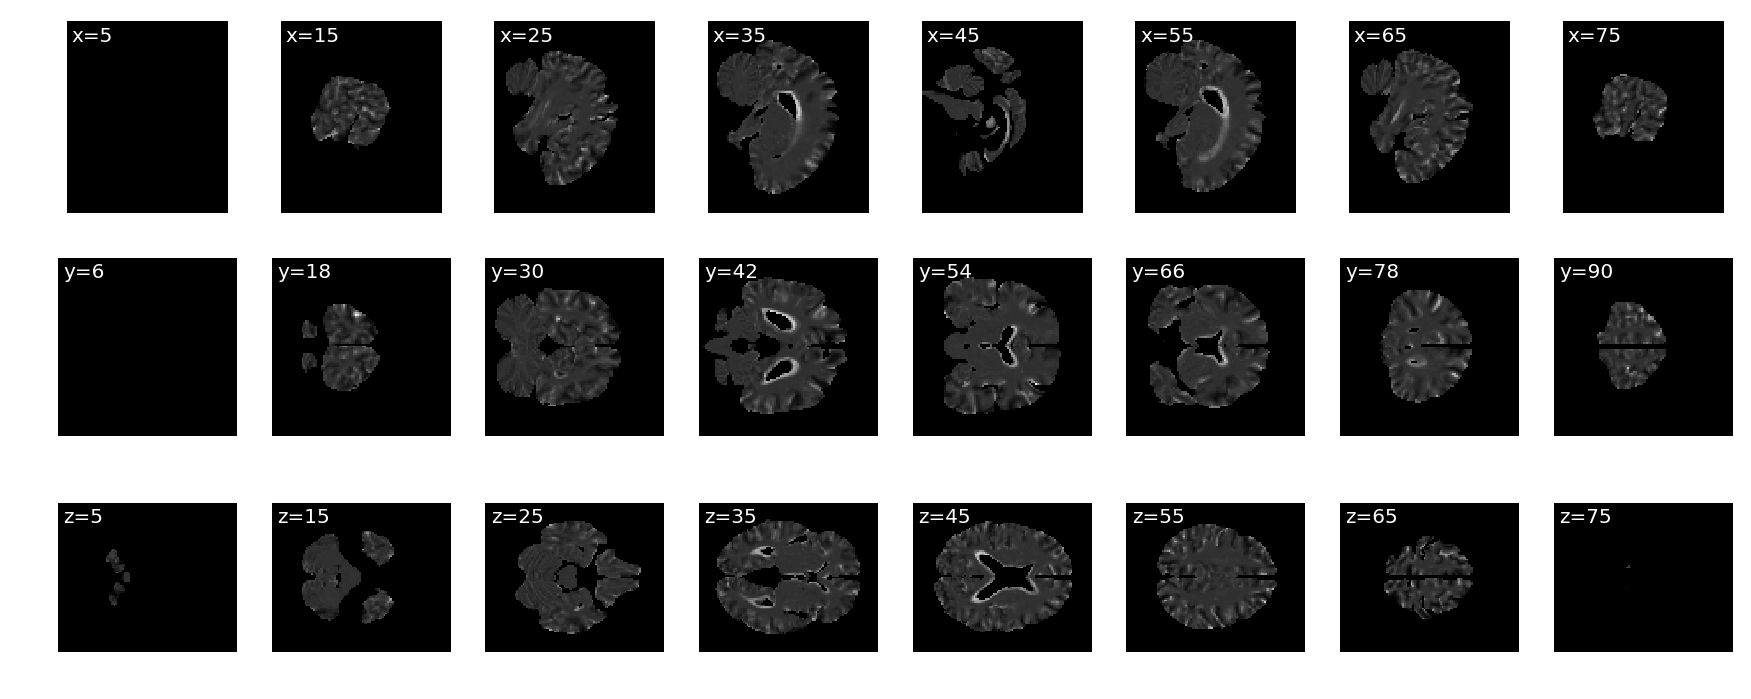

In [87]:
plot_slices(train_dataset[0][0][0])

-0.0 6.60129442755 None None


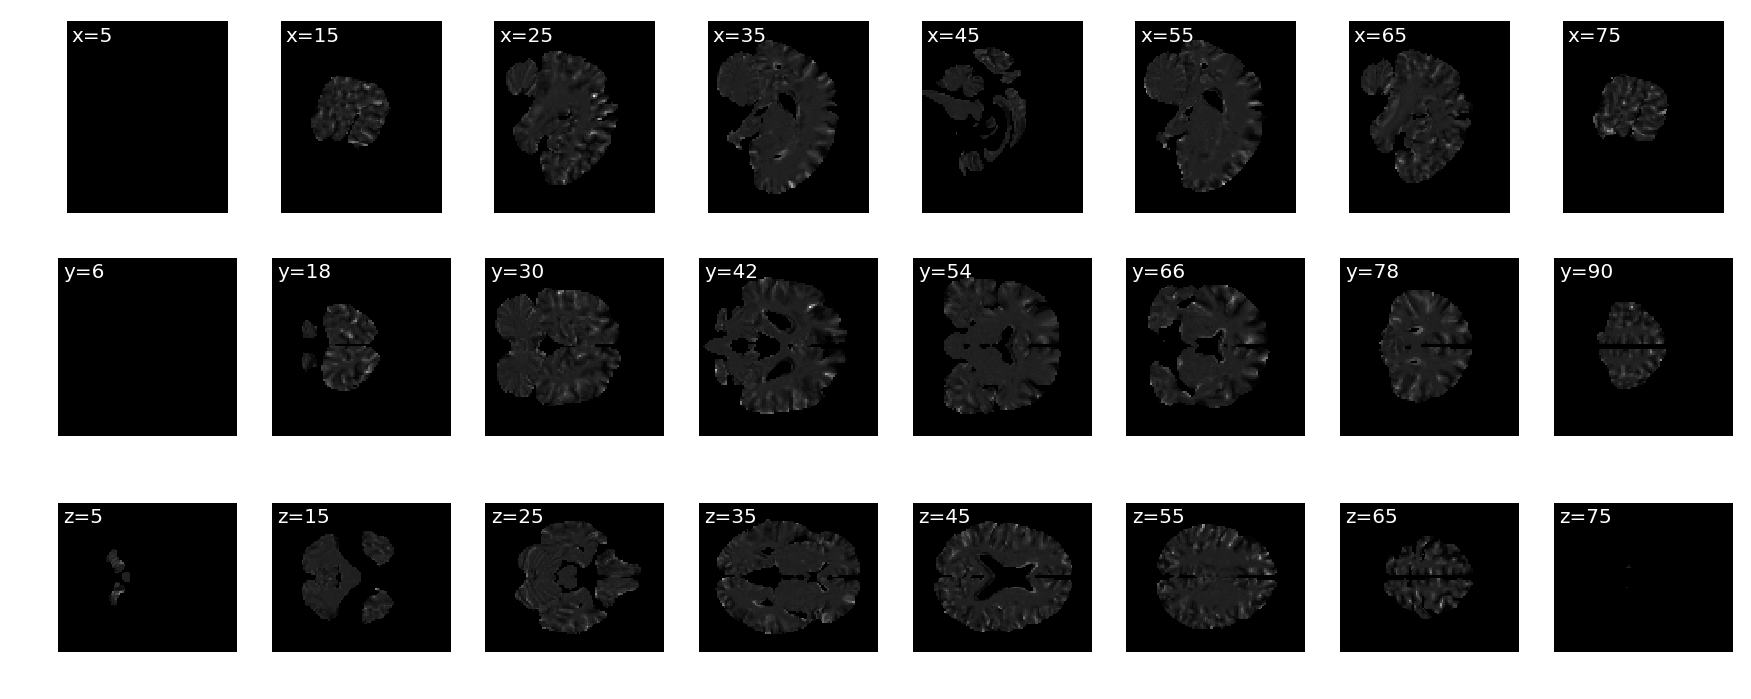

In [94]:
plot_slices((all_struct_arr[5]) / (all_struct_arr.std(0) + e))

In [104]:
from tabulate import tabulate

     min       max      mean      std
--------  --------  --------  -------
  0        878.652  138.734   147.395
  0       1080.93   139.514   164.709
  0       2475.49   458.859   498.345
  0       1032.4    167.046   167.691
  0        634.653  107.298   112.158
  0        746.643  111.941   123.482
-73.1235  2943.86   374.188   433.29
  0        611.206   99.4162  108.139
  0        766.627  105.494   116.77
  0        725.335  116.1     118.207


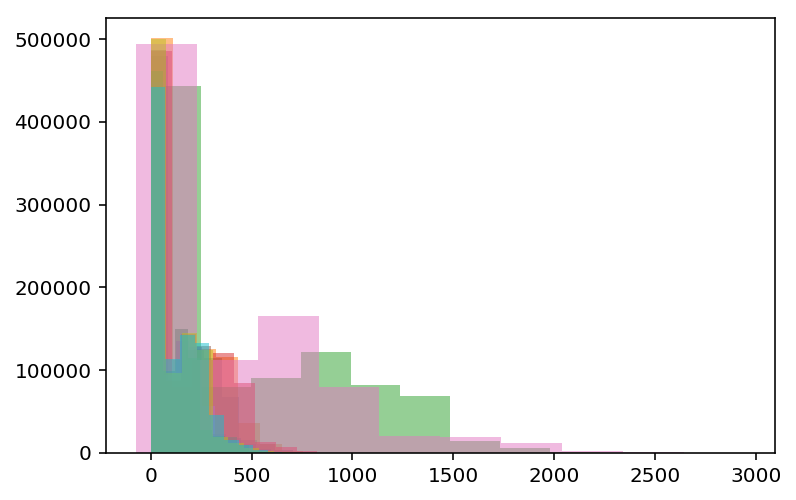

In [105]:
# Without mask.
table = []
for filename in os.listdir(data_dir)[:10]:
    struct_arr = load_nifti(os.path.join(data_dir, filename))
    table.append([struct_arr.min(), struct_arr.max(), struct_arr.mean(), struct_arr.std()])
    plt.hist(struct_arr.flatten(), alpha=0.5)
print(tabulate(table, headers=['min', 'max', 'mean', 'std']))

  min       max      mean       std
-----  --------  --------  --------
   -0   448.312   58.3633  119.693
   -0   916.809   69.1425  140.556
   -0  1893.51   210.079   426.996
   -0   642.567   71.6904  146.938
   -0   405.869   42.5109   85.8336
   -0   535.572   44.9789   91.5871
   -0  1208.63   135.899   282.577
   -0   440.731   34.3401   70.2301
   -0   435.472   45.4274   93.2796
   -0   383.535   46.64     94.91


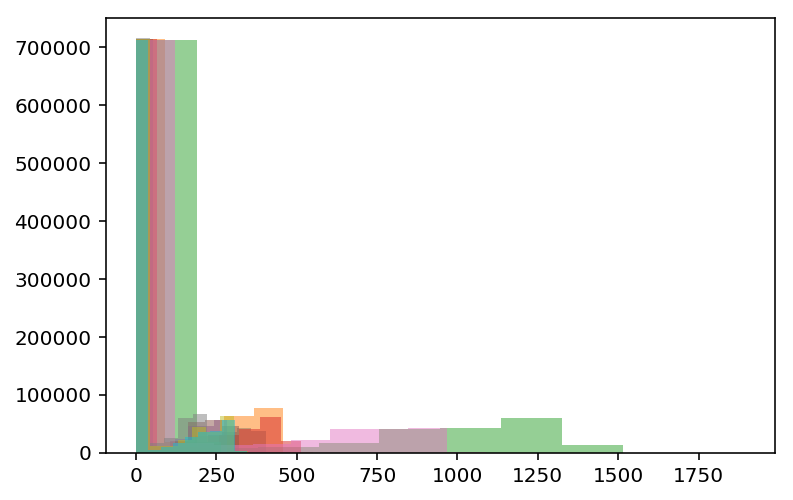

In [106]:
# With mask.
table = []
for filename in os.listdir(data_dir)[:10]:
    struct_arr = load_nifti(os.path.join(data_dir, filename), mask=mask)
    
    # Normalize.
    #struct_arr = (struct_arr - all_struct_arr.mean()) / (all_struct_arr.std() + e)
    
    table.append([struct_arr.min(), struct_arr.max(), struct_arr.mean(), struct_arr.std()])
    plt.hist(struct_arr.flatten(), alpha=0.5)
print(tabulate(table, headers=['min', 'max', 'mean', 'std']))

# Option 1: Small dataset

In [6]:
# Load a mask that is applied to all nifti images and strips the skull etc.
mask = load_nifti('data/WM_GM_mask.nii.gz', z_factor=0.75)

/home/johannesr/anaconda2/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [7]:
# Local
#data_dir = 'data/adni-sample'

# Remote (Ubuntu)
data_dir = '/analysis/share/Fabi_Kerstin/AD_vs_HC_50_vs_49/'

In [8]:
filenames = filter(lambda filename: filename.endswith('nii'), os.listdir(data_dir))
labels = map(lambda filename: 1 if filename.startswith('AD') else 0, filenames)
labels = np.array(labels)[:, None]
filenames = [os.path.join(data_dir, filename) for filename in filenames]
len(filenames), filenames[:5], labels[:5]

(98,
 [u'/analysis/share/Fabi_Kerstin/AD_vs_HC_50_vs_49/AD_0076_wT1.nii',
  u'/analysis/share/Fabi_Kerstin/AD_vs_HC_50_vs_49/NC_4264_wT1.nii',
  u'/analysis/share/Fabi_Kerstin/AD_vs_HC_50_vs_49/NC_4026_wT1.nii',
  u'/analysis/share/Fabi_Kerstin/AD_vs_HC_50_vs_49/AD_0213_wT1.nii',
  u'/analysis/share/Fabi_Kerstin/AD_vs_HC_50_vs_49/NC_4090_wT1.nii'],
 array([[1],
        [0],
        [0],
        [1],
        [0]]))

# Option 2: Complete dataset (3T)

In [6]:
mask = load_nifti('/analysis/share/Ritter/Templates/mni_icbm152_nlin_asym_09c/binary_brain_mask.nii.gz')

In [7]:
images_root_dir = '/analysis/share/ADNI/ADNI_2Yr_3T_preprocessed'
table_path = '/analysis/share/ADNI/ADNI_tables/customized/DxByImgClean_CompleteAnnual2YearVisitList_3T.csv'

In [52]:
df = pd.read_csv(table_path)
df

RID        PTID VISCODE        DX    EXAMDATE  Image.ID Scan.Date  \
0      15  100_S_0015      bl        CN  2005-10-18     33046  10/31/05   
1      15  100_S_0015     m12        CN  2006-10-13     63475  10/16/06   
2      15  100_S_0015     m24        CN  2007-10-11     82551  10/11/07   
3      30  023_S_0030      bl       MCI  2005-10-20     31623  10/26/05   
4      30  023_S_0030      bl       MCI  2005-10-20    118790  10/26/05   
5      30  023_S_0030     m12  Dementia  2006-10-12    138580  10/12/06   
6      30  023_S_0030     m24  Dementia  2007-11-13     87493  11/13/07   
7      58  023_S_0058      bl        CN  2005-12-12     30968  12/12/05   
8      58  023_S_0058      bl        CN  2005-12-12    118837  12/12/05   
9      58  023_S_0058     m12        CN  2006-12-19    118852  12/19/06   
10     58  023_S_0058     m24        CN  2007-12-06     87046   12/6/07   
11     61  023_S_0061      bl        CN  2005-12-15     31107  12/20/05   
12     61  023_S_0061      bl        CN  2005-12-15    118854  12/20/05   
13     61  023_S_0061     m12        CN  2006-12-07     81874   12/6/06   
14     61  023_S_0061     m12        CN  2006-12-07    118858   12/6/06   
15     61  023_S_0061     m24        CN  2007-12-13     87064  12/13/07   
16     86  136_S_0086      bl        CN  2006-05-08     40172    5/8/06   
17     86  136_S_0086      bl        CN  2006-05-08    119685    5/8/06   
18     86  136_S_0086     m12        CN  2007-05-01     67781    5/1/07   
19     86  136_S_0086     m24        CN  2008-05-05    120416    5/5/08   
20    184  136_S_0184      bl        CN  2006-03-27     40191   3/27/06   
21    184  136_S_0184      bl        CN  2006-03-27    119712   3/27/06   
22    184  136_S_0184     m12        CN  2007-03-19     69136   3/20/07   
23    184  136_S_0184     m24        CN  2008-03-17    102840   3/17/08   
24    190  100_S_0190      bl  Dementia  2006-05-16     33114   5/22/06   
25    190  100_S_0190     m12  Dementia  2007-05-08     82556   5/10/07   
26    190  100_S_0190     m24  Dementia  2008-05-01    106524   5/12/08   
27    195  136_S_0195      bl       MCI  2006-04-04     40254    4/4/06   
28    195  136_S_0195      bl       MCI  2006-04-04    119721    4/4/06   
29    195  136_S_0195     m12  Dementia  2007-03-26     81981   3/26/07   
..    ...         ...     ...       ...         ...       ...       ...   
249  1249  116_S_1249     m12        CN  2008-02-13     91921    2/6/08   
250  1249  116_S_1249     m24        CN  2009-02-17    139325    2/4/09   
251  1261  002_S_1261      bl        CN  2007-02-27     65561   2/27/07   
252  1261  002_S_1261     m12        CN  2008-06-09    132220   5/27/08   
253  1261  002_S_1261     m24        CN  2009-02-05    136188    2/5/09   
254  1262  023_S_1262      bl  Dementia  2007-03-01     64862   2/28/07   
255  1262  023_S_1262      bl  Dementia  2007-03-01    118924   2/28/07   
256  1262  023_S_1262     m12  Dementia  2008-04-02    103276    4/2/08   
257  1262  023_S_1262     m24  Dementia  2009-03-13    143685   3/13/09   
258  1268  002_S_1268      bl       MCI  2007-03-07     65268    3/7/07   
259  1268  002_S_1268     m12       MCI  2008-05-12    108422   5/22/08   
260  1268  002_S_1268     m24       MCI  2009-03-13    140734    3/4/09   
261  1280  002_S_1280      bl        CN  2007-02-27     65874   2/27/07   
262  1280  002_S_1280     m12        CN  2008-03-25    104471   3/25/08   
263  1280  002_S_1280     m24        CN  2009-02-19    140739   2/19/09   
264  1286  100_S_1286      bl        CN  2007-02-23     82571    3/7/07   
265  1286  100_S_1286     m12        CN  2008-02-12     96312   2/11/08   
266  1286  100_S_1286     m24        CN  2009-03-10    149636   3/17/09   
267  1326  016_S_1326      bl       MCI  2007-03-27     86345    4/2/07   
268  1326  016_S_1326     m12       MCI  2008-03-27    102675   3/31/08   
269  1326  016_S_1326     m24  Dementia  2009-04-01    143554   4/13/09   
270  1331  051_S_1331      bl  

Important columns in the table:

- PTID: Patient ID
- VISCODE: Visit code (bl=baseline, mx=after x months) (see also Visit)
- DX: Diagnosis (CN=control, MCI=mild cognitive impairment, Dementia=Alzheimer's disease)
- Image.ID: Image ID

The filenames of the corresponding images are: `<PTID>_<Scan.Date with - instead of />_<Visit>_<Image.ID>_<DX>.nii`

In [53]:
# TODO: Filter out patients with corrupted scans.
# These are the images where preprocessing failed.
corrupt_images = ['037_S_0501/Baseline', '037_S_0501/Month12', '037_S_0501/Month24', '051_S_1123/Baseline', '051_S_1123/Month12', '051_S_1123/Month24', '116_S_0649/Month12', '116_S_0649/Month24', '116_S_1232/Baseline', '027_S_1387/Baseline', '027_S_1387/Month12', '027_S_1387/Month24', '116_S_0382/Baseline', '027_S_0404/Baseline', '027_S_0404/Month24', '027_S_1385/Month12', '023_S_0376/Month12', '023_S_0030/Baseline', '023_S_0030/Month24', '023_S_1247/Baseline', '023_S_1247/Month12', '027_S_1082/Month24', '018_S_0450/Baseline', '005_S_0572/Baseline', '005_S_0572/Month12', '005_S_0572/Month24']

In [54]:
corrupt_indices = df.apply(lambda row: '{}/{}'.format(row['PTID'], row['Visit']) in corrupt_images, axis=1)
print('Filtering out', np.sum(corrupt_indices), 'rows with corrupt images')
df = df[np.invert(corrupt_indices)]

Filtering out 11 rows with corrupt images


In [55]:
filenames = df.apply(get_image_filepath, root_dir=images_root_dir, axis=1)
idx_file_exists = map(os.path.exists, filenames)
print('Filtering out', np.sum(np.invert(idx_file_exists)), 'rows with missing files')
df = df[idx_file_exists]

Filtering out 2 rows with missing files


In [56]:
df['DX'].value_counts()

CN          90
MCI         89
Dementia    87
Name: DX, dtype: int64

In [57]:
# Filter out rows with MCI, they are not handled for now.
idx_MCI = df['DX'] == 'MCI'
print('Filtering out', np.sum(idx_MCI), 'rows with MCI')
df = df[np.invert(idx_MCI)]

Filtering out 89 rows with MCI


In [58]:
# Split into patients with and without Dementia.
patients_AD = df[df['DX'] == 'Dementia']['PTID'].unique()
patients_CN = df[df['DX'] == 'CN']['PTID'].unique()
# Patients that have both a CN and an AD scan should belong to the AD group.
patients_CN = filter(lambda p: p not in patients_AD, patients_CN)

print('Patients with CN:', len(patients_CN))
print('Patients with AD:', len(patients_AD))

Patients with CN: 28
Patients with AD: 36


In [59]:
def fixed_train_test_split(arr, test_size=10, seed=None):
    """Split an array into train and test set with a fixed number of samples for the test set."""
    if seed is not None:
        np.random.seed(seed)
    arr_permuted = np.random.permutation(arr)
    return arr_permuted[test_size:], arr_permuted[:test_size]

In [91]:
# Put 10 patients each into the validation set.
val_size = 10
patients_AD_train, patients_AD_val = fixed_train_test_split(patients_AD, test_size=val_size, seed=1)
patients_CN_train, patients_CN_val = fixed_train_test_split(patients_CN, test_size=val_size, seed=1)

In [92]:
# TODO: Introduce test set.
patients_train = np.concatenate([patients_AD_train, patients_CN_train])
patients_val = np.concatenate([patients_AD_val, patients_CN_val])

# TODO: Check that no patients are in both groups.
print('Patients for train: {} ({} with CN, {} with AD)'.format(len(patients_train), len(patients_CN_train), len(patients_AD_train)))
print('Patients for val: {} ({} with CN, {} with AD)'.format(len(patients_val), len(patients_CN_val), len(patients_AD_val)))

Patients for train: 44 (18 with CN, 26 with AD)
Patients for val: 20 (10 with CN, 10 with AD)


In [93]:
df_train = df[df.apply(lambda row: row['PTID'] in patients_train, axis=1)]
df_val = df[df.apply(lambda row: row['PTID'] in patients_val, axis=1)]

In [94]:
df_train

RID        PTID VISCODE        DX    EXAMDATE  Image.ID Scan.Date  \
0      15  100_S_0015      bl        CN  2005-10-18     33046  10/31/05   
1      15  100_S_0015     m12        CN  2006-10-13     63475  10/16/06   
2      15  100_S_0015     m24        CN  2007-10-11     82551  10/11/07   
5      30  023_S_0030     m12  Dementia  2006-10-12    138580  10/12/06   
6      30  023_S_0030     m24  Dementia  2007-11-13     87493  11/13/07   
7      58  023_S_0058      bl        CN  2005-12-12     30968  12/12/05   
8      58  023_S_0058      bl        CN  2005-12-12    118837  12/12/05   
9      58  023_S_0058     m12        CN  2006-12-19    118852  12/19/06   
10     58  023_S_0058     m24        CN  2007-12-06     87046   12/6/07   
11     61  023_S_0061      bl        CN  2005-12-15     31107  12/20/05   
12     61  023_S_0061      bl        CN  2005-12-15    118854  12/20/05   
13     61  023_S_0061     m12        CN  2006-12-07     81874   12/6/06   
14     61  023_S_0061     m12        CN  2006-12-07    118858   12/6/06   
15     61  023_S_0061     m24        CN  2007-12-13     87064  12/13/07   
24    190  100_S_0190      bl  Dementia  2006-05-16     33114   5/22/06   
25    190  100_S_0190     m12  Dementia  2007-05-08     82556   5/10/07   
26    190  100_S_0190     m24  Dementia  2008-05-01    106524   5/12/08   
29    195  136_S_0195     m12  Dementia  2007-03-26     81981   3/26/07   
30    195  136_S_0195     m24  Dementia  2008-03-25    120423   3/25/08   
31    196  136_S_0196      bl        CN  2006-05-01     40269    5/1/06   
32    196  136_S_0196      bl        CN  2006-05-01    119725    5/1/06   
33    196  136_S_0196     m12        CN  2007-05-07     66740    5/7/07   
34    196  136_S_0196     m24        CN  2008-04-28    120426   4/28/08   
35    260  127_S_0260      bl        CN  2006-05-02     34371    5/1/06   
36    260  127_S_0260     m12        CN  2007-05-09     63565    5/8/07   
37    260  127_S_0260     m24        CN  2008-05-13    106542   5/13/08   
46    303  037_S_0303      bl        CN  2006-05-03     64116    5/3/06   
47    303  037_S_0303     m12        CN  2007-04-25    138806   4/25/07   
48    303  037_S_0303     m24        CN  2008-04-23    105924    5/6/08   
60    335  018_S_0335      bl  Dementia  2006-05-31     35014   5/31/06   
..    ...         ...     ...       ...         ...       ...       ...   
194   963  023_S_0963      bl        CN  2006-10-17    118904  10/17/06   
195   963  023_S_0963     m12        CN  2007-10-11     82205  10/11/07   
196   963  023_S_0963     m24        CN  2008-11-24    129286  11/24/08   
211  1066  031_S_1066     m12  Dementia  2007-12-14     87106  12/14/07   
212  1066  031_S_1066     m24  Dementia  2008-11-25    129313  11/25/08   
215  1070  002_S_1070     m24  Dementia  2008-12-11    132215  12/11/08   
219  1082  027_S_1082      bl  Dementia  2006-12-06     47186  12/13/06   
220  1082  027_S_1082     m12  Dementia  2007-12-13     86377   12/5/07   
221  1082  027_S_1082     m24  Dementia  2008-12-03    132359   12/8/08   
242  1232  116_S_1232     m12        CN  2008-02-06     91912   1/30/08   
243  1232  116_S_1232     m24        CN  2009-02-04    142425    2/5/09   
246  1247  023_S_1247     m12  Dementia  2008-01-29     91703   1/29/08   
247  1247  023_S_1247     m24  Dementia  2009-03-12    143116   3/12/09   
251  1261  002_S_1261      bl        CN  2007-02-27     65561   2/27/07   
252  1261  002_S_1261     m12        CN  2008-06-09    132220   5/27/08   
253  1261  002_S_1261     m24        CN  2009-02-05    136188    2/5/09   
254  1262  023_S_1262      bl  Dementia  2007-03-01     64862   2/28/07   
255  1262  023_S_1262      bl  Dementia  2007-03-01    118924   2/28/07   
256  1262  023_S_1262     m12  Dementia  2008-04-02    103276    4/2/08   
257  1262  023_S_1262     m24  Dementia  2009-03-13    143685   3/13/09   
261  1280  002_S_1280      bl        CN  2007-02-27     65874   2/27/07   
262  1280  002_S_1280     m12  

In [95]:
df_val

RID        PTID VISCODE        DX    EXAMDATE  Image.ID Scan.Date  \
16     86  136_S_0086      bl        CN  2006-05-08     40172    5/8/06   
17     86  136_S_0086      bl        CN  2006-05-08    119685    5/8/06   
18     86  136_S_0086     m12        CN  2007-05-01     67781    5/1/07   
19     86  136_S_0086     m24        CN  2008-05-05    120416    5/5/08   
20    184  136_S_0184      bl        CN  2006-03-27     40191   3/27/06   
21    184  136_S_0184      bl        CN  2006-03-27    119712   3/27/06   
22    184  136_S_0184     m12        CN  2007-03-19     69136   3/20/07   
23    184  136_S_0184     m24        CN  2008-03-17    102840   3/17/08   
42    300  136_S_0300      bl  Dementia  2006-05-22     40352    6/7/06   
43    300  136_S_0300      bl  Dementia  2006-05-22    119729    6/7/06   
44    300  136_S_0300     m12  Dementia  2007-05-29     66768   5/29/07   
45    300  136_S_0300     m24  Dementia  2008-05-19    120436   5/19/08   
80    403  027_S_0403      bl        CN  2006-05-04     34190    5/8/06   
81    403  027_S_0403     m12        CN  2007-05-08     67380   5/14/07   
82    403  027_S_0403     m24        CN  2008-05-05    105888   5/12/08   
124   559  002_S_0559      bl        CN  2006-06-20     45126   6/27/06   
125   559  002_S_0559      bl        CN  2006-06-20    118679   6/27/06   
126   559  002_S_0559     m12        CN  2007-07-13     82102  10/18/07   
127   559  002_S_0559     m24        CN  2008-08-11    120779   8/15/08   
169   729  002_S_0729     m12  Dementia  2007-09-05     78663    9/5/07   
170   729  002_S_0729     m24  Dementia  2008-08-28    124008   9/29/08   
179   835  027_S_0835     m24  Dementia  2008-09-16    120256   9/23/08   
183   916  023_S_0916      bl  Dementia  2006-09-26     31540   9/29/06   
184   916  023_S_0916      bl  Dementia  2006-09-26    118880   9/29/06   
185   916  023_S_0916     m12  Dementia  2007-10-02     80152   9/28/07   
186   916  023_S_0916     m24  Dementia  2008-09-30    124097   9/30/08   
187   926  023_S_0926      bl        CN  2006-10-16    138627  10/16/06   
188   926  023_S_0926     m12        CN  2007-10-23     81937  10/23/07   
189   926  023_S_0926     m24        CN  2008-10-21    125029  10/21/08   
197   969  130_S_0969      bl        CN  2006-11-03     39203   11/6/06   
198   969  130_S_0969     m12        CN  2007-11-02     92363   11/7/07   
199   969  130_S_0969     m24        CN  2008-11-06    132451  11/19/08   
200  1009  012_S_1009      bl        CN  2006-11-30     59214   11/3/06   
202  1009  012_S_1009     m24        CN  2008-12-09    132800   12/9/08   
203  1018  002_S_1018      bl  Dementia  2006-12-14     40828  12/18/06   
204  1018  002_S_1018     m12  Dementia  2007-12-07     97022   12/7/07   
205  1018  002_S_1018     m24  Dementia  2008-12-12    132795  12/12/08   
216  1081  027_S_1081      bl  Dementia  2007-02-05     47177    2/8/07   
217  1081  027_S_1081     m12  Dementia  2008-02-05     94432   2/11/08   
218  1081  027_S_1081     m24  Dementia  2009-02-04    135775    2/4/09   
227  1121  016_S_1121     m24  Dementia  2008-12-15    135570  12/23/08   
229  1123  051_S_1123     m12        CN  2008-02-18     94563   2/18/08   
230  1123  051_S_1123     m24        CN  2009-02-18    142107   2/23/09   
233  1126  023_S_1126     m12  Dementia  2007-12-04     94863  11/28/07   
234  1126  023_S_1126     m24  Dementia  2009-02-06    136193    2/6/09   
235  1209  031_S_1209      bl  Dementia  2007-01-31     90925   1/31/07   
236  1209  031_S_1209     m12  Dementia  2008-02-08     92205    2/8/08   
237  1209  031_S_1209     m24  Dementia  2009-02-10    142001   2/10/09   
238  1222  007_S_1222      bl        CN  2007-02-06     59986    2/7/07   
239  1222  007_S_1222     m12        CN  2008-02-21     96052   2/22/08   
240  1222  007_S_1222     m24        CN  2009-02-19    140800   2/19/09   
248  1249  116_S_1249      bl        CN  2007-02-14     53845    3/1/07   
249  1249  116_S_1249     m12  

In [96]:
train_filenames = np.array(df_train.apply(get_image_filepath, root_dir=images_root_dir, axis=1))
val_filenames = np.array(df_val.apply(get_image_filepath, root_dir=images_root_dir, axis=1))

In [97]:
train_labels = np.array(df_train['DX'] == 'Dementia', dtype=int)[:, None]
val_labels = np.array(df_train['DX'] == 'Dementia', dtype=int)[:, None]

In [29]:
def get_image_filepath(df_row, root_dir=''):
    """Return the filepath to the image that belongs to a row in the dataframe."""
    filename = 'INTERNAL_WARPED.nii.gz'#"{}_{}_{}_{}_{}.nii".format(df_row['PTID'], df_row['Scan.Date'].replace('/', '-'), df_row['Visit'], df_row['Image.ID'], df_row['DX'])
    filepath = os.path.join(root_dir, df_row['PTID'], df_row['Visit'].replace(' ', ''), filename)
    return filepath

get_image_filepath(df.loc[0])

u'100_S_0015/Baseline/INTERNAL_WARPED.nii.gz'

In [11]:
# Get all images for each diagnosis.
import collections

image_filepaths = collections.defaultdict(list)#{}

# TODO: Filter out images where preprocessing failed.
for diagnosis in ['CN', 'MCI', 'Dementia']:
    for _, row in df[df['DX'] == diagnosis].iterrows():
        image_filepath = get_image_filepath(row, root_dir=images_root_dir)
        if os.path.exists(image_filepath):
            image_filepaths[diagnosis].append(image_filepath)
        else:
            print('File does not exist:', image_filepath)
        
     #   image_filepaths[diagnosis].append(image_filepath)
    print('{}: Added {} files'.format(diagnosis, len(image_filepaths[diagnosis])))
    #image_filepaths[diagnosis] = list(df[df['DX'] == diagnosis].apply(get_image_filepath, axis=1, root_dir=images_root_dir))

CN: Added 93 files
File does not exist: /analysis/share/ADNI/ADNI_2Yr_3T_preprocessed/037_S_0501/Month12/INTERNAL_WARPED.nii.gz
MCI: Added 97 files
File does not exist: /analysis/share/ADNI/ADNI_2Yr_3T_preprocessed/027_S_1387/Month24/INTERNAL_WARPED.nii.gz
Dementia: Added 87 files


In [12]:
filenames = np.asarray(image_filepaths['CN'] + image_filepaths['Dementia'])
labels = np.zeros((len(filenames), 1))
labels[len(image_filepaths['CN']):, 0] = 1

# Set up model

In [79]:
class ClassificationModel3D(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.Conv_1 = nn.Conv3d(1, 32, 3)
        self.Conv_2 = nn.Conv3d(32, 32, 3)
        self.Conv_3 = nn.Conv3d(32, 32, 3)
        #self.Conv_1 = nn.Conv3d(1, 64, 3)
        #self.Conv_2 = nn.Conv3d(64, 64, 3)
        #self.Conv_3 = nn.Conv3d(64, 64, 3)
        #self.Conv_4 = nn.Conv3d(64, 64, 3)
        #self.Conv_5 = nn.Conv3d(64, 64, 3)
        # TODO: Probably it makes more sense to reduce the number of neurons here, i.e. apply a larger stride and/or pooling above.
        self.dense_1 = nn.Linear(64, 1)
        #self.dense_1 = nn.Linear(128, 1)
        self.elu = nn.ELU()
        
    def forward(self, inp):
        x = self.elu(self.Conv_1(inp))  # TODO: Probably need relu for guided backprop!
        x = F.max_pool3d(x, 5)
        x = self.elu(self.Conv_2(x))
        x = F.max_pool3d(x, 5)
        x = self.elu(self.Conv_3(x))
        x = F.max_pool3d(x, 3)
        #x = self.elu(self.Conv_4(x))
        #x = F.max_pool3d(x, 3)
        #x = F.elu(self.Conv_5(x))
        #x = F.max_pool3d(x, 3)
        x = x.view(x.size(0), -1)
        x = self.dense_1(x)
        
        # Only apply the sigmoid in eval mode, because during training we use the BCEWithLogitsLoss,
        # which includes the sigmoid and is numerically more stable.
        if not self.training:
            #print('Adding sigmoid')
            x = F.sigmoid(x)
            
        return x

In [98]:
net = ClassificationModel3D()

In [99]:
optimizer = torch.optim.RMSprop(net.parameters(), lr=0.0001)
loss_function = nn.BCEWithLogitsLoss()

In [100]:
from torchsample.modules import ModuleTrainer
from torchsample.metrics import BinaryAccuracy

In [101]:
trainer = ModuleTrainer(net)
# TODO: Implement a metric BinaryAccuracyWithLogits to account for the BCEWithLogitsLoss function.
trainer.compile(loss=loss_function, optimizer=optimizer, metrics=[BinaryAccuracy()], callbacks=[])

In [102]:
trainer.summary([1, 193, 229, 193])
#trainer.summary([1, 91, 109, 91])

OrderedDict([('Conv3d-1',
              OrderedDict([('input_shape', [-1, 1L, 193L, 229L, 193L]),
                           ('output_shape', [-1, 32L, 191L, 227L, 191L]),
                           ('trainable', True),
                           ('nb_params', 896)])),
             ('ELU-2',
              OrderedDict([('input_shape', [-1, 32L, 191L, 227L, 191L]),
                           ('output_shape', [-1, 32L, 191L, 227L, 191L]),
                           ('nb_params', 0)])),
             ('Conv3d-3',
              OrderedDict([('input_shape', [-1, 32L, 38L, 45L, 38L]),
                           ('output_shape', [-1, 32L, 36L, 43L, 36L]),
                           ('trainable', True),
                           ('nb_params', 27680)])),
             ('ELU-4',
              OrderedDict([('input_shape', [-1, 32L, 36L, 43L, 36L]),
                           ('output_shape', [-1, 32L, 36L, 43L, 36L]),
                           ('nb_params', 0)])),
             ('Conv3d-5',
       

In [85]:
if torch.cuda.is_available():
    net = net.cuda()
    cuda_device = torch.cuda.current_device()
    print('Moved network to GPU')
else:
    cuda_device = -1
    print('GPU not available')

Moved network to GPU


## On small test dataset (OLD)

In [145]:
# TODO: This is a dirty workaround and only calculates the std across 10 images. Implement a nice way to get the std and mean across all samples.
# TODO: Do not actually calculate these values here, but preserve them somewhere.
pixel_std = all_struct_arr.std(0)

In [146]:
# TODO: Maybe inherit from torchsample.datasets.BaseDataset instead.
class ADNIDataset(Dataset):
    
    # TODO: Maybe give mask as filename here.
    def __init__(self, root_dir, mask=None, remove_nan=True, transform=None):
        self.root_dir = root_dir
        self.filenames = filter(lambda filename: filename.endswith('nii'), os.listdir(self.root_dir))
        print('Found', len(self.filenames), 'files')
        self.mask = mask
        self.remove_nan = remove_nan
        self.transform = transform
        
        # Required by torchsample.
        self.num_inputs = 1
        self.num_targets = 1
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        filename = self.filenames[idx]
        struct_arr = load_nifti(os.path.join(self.root_dir, filename), mask=self.mask, remove_nan=self.remove_nan)
    
        # TODO: Maybe do this (at least the normalization) via transforms.
        struct_arr = struct_arr / (pixel_std + e)
        struct_arr = struct_arr[None]  # add (empty) channel dimension
        struct_arr = torch.from_numpy(struct_arr).float()
        
        if self.transform is not None:
            struct_arr = self.transform(struct_arr)
        
        label = torch.ones(1) if filename.startswith('AD') else torch.zeros(1)
        return struct_arr, label

In [147]:
train_dataset = ADNIDataset(data_dir, mask=mask)
val_dataset = ADNIDataset(data_dir, mask=mask)

Found 98 files
Found 98 files


# Train

In [86]:
# New Dataset class to read all images.

# TODO: Maybe inherit from torchsample.datasets.BaseDataset instead.
class ADNIDataset(Dataset):
    
    # TODO: Maybe give mask as filename here.
    def __init__(self, filenames, labels, mask=None, remove_nan=True, transform=None):
            
        self.filenames = filenames
        self.labels = torch.Tensor(labels)
        
        
        #self.root_dir = root_dir
        #self.filenames = filter(lambda filename: filename.endswith('nii'), os.listdir(self.root_dir))
        #print('Found', len(self.filenames), 'files')
        self.mask = mask
        self.remove_nan = remove_nan
        self.transform = transform
        
        # Required by torchsample.
        self.num_inputs = 1
        self.num_targets = 1
        
        self.mean = 0
        self.std = 1
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        label = self.labels[idx]
            
        struct_arr = load_nifti(self.filenames[idx], mask=self.mask, remove_nan=self.remove_nan)
    
        # TODO: Maybe do this (at least the normalization) via transforms.
        # TODO: Maybe do normalization via mean as well.
        struct_arr = struct_arr / (self.std + e)
        struct_arr = struct_arr[None]  # add (empty) channel dimension
        struct_arr = torch.from_numpy(struct_arr).float()
        
        if self.transform is not None:
            struct_arr = self.transform(struct_arr)
        
        #label = torch.ones(1) if filename.startswith('AD') else torch.zeros(1)
        return struct_arr, label
    
    def image_shape(self):
        return load_nifti(self.filenames[0], mask=mask).shape
    
    def get_std_and_mean(self, num_sample=None):
        if num_sample is None:
            num_sample = len(self)
        
        image_shape = self.image_shape()
        all_struct_arr = np.zeros((num_sample, image_shape[0], image_shape[1], image_shape[2]))
        
        for i, filename in enumerate(np.random.choice(self.filenames, num_sample, replace=False)):
            struct_arr = load_nifti(filename, mask=mask, remove_nan=self.remove_nan)
            all_struct_arr[i] = struct_arr
            
        return all_struct_arr.std(0), all_struct_arr.mean(0)
    
    def get_raw_image(self, idx):
        return load_nifti(self.filenames[idx], mask=self.mask, remove_nan=self.remove_nan)

In [21]:
#import torchvision, torchsample 

#transform = torchvision.transforms.Compose([
#    torchsample.transforms.ToTensor(),  # do not use the torchvision version, as is also normalizes from (0, 255) to (0, 1)
#    # TODO: Try voxel-wise normalization here.
#    torchvision.transforms.Normalize([53], [125])
#])

In [22]:
from sklearn.model_selection import train_test_split
train_filenames, val_filenames, train_labels, val_labels = train_test_split(filenames, labels)

In [87]:
train_dataset = ADNIDataset(train_filenames, train_labels, mask=mask)
val_dataset = ADNIDataset(val_filenames, val_labels, mask=mask)

In [88]:
# TODO: Maybe normalize each scan first, so that they are on a common scale.
# TODO: Maybe add mean normalization.
std, mean = train_dataset.get_std_and_mean(10)
train_dataset.std = std
val_dataset.std = std

In [89]:
# TODO: Reset batch_size to 1.
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2, pin_memory=True) # use pin_memory=True with CUDA only
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

In [90]:
# TODO: acc_metric is flawed because in train mode, the network outputs the raw logits, so rounding these values and comparing to the true values doesn't make sense.
trainer.fit_loader(train_loader,
            val_loader=val_loader,
            num_epoch=20, 
            verbose=1,
            cuda_device=cuda_device)

Epoch 1/20: : 122 batches [01:00,  6.03s/ batches, acc_metric=37.0607, loss=0.7257, val_acc_metric=37.5000, val_loss=0.7868]                 
Epoch 2/20: : 122 batches [01:00,  6.05s/ batches, acc_metric=52.5327, loss=0.6517, val_acc_metric=53.5714, val_loss=0.7766]                 
Epoch 3/20: : 122 batches [01:00,  6.04s/ batches, acc_metric=39.5983, loss=0.6206, val_acc_metric=37.5000, val_loss=0.7913]                 
Epoch 4/20: : 122 batches [01:00,  6.05s/ batches, acc_metric=48.1578, loss=0.5811, val_acc_metric=58.9286, val_loss=0.7538]                 
Epoch 5/20: : 122 batches [01:01,  6.10s/ batches, acc_metric=40.5887, loss=0.5558, val_acc_metric=64.2857, val_loss=0.7727]                 
Epoch 6/20: : 122 batches [01:01,  6.09s/ batches, acc_metric=44.9809, loss=0.5144, val_acc_metric=55.3571, val_loss=0.7645]                 
Epoch 7/20: : 122 batches [00:59,  6.04s/ batches, acc_metric=36.5451, loss=0.4769, val_acc_metric=60.7143, val_loss=0.7600]                 
Epoch 

In [214]:
# TODO: Add timestamp to model filename.
#torch.save(net, 'data/models/pytorch_model_.p')
torch.save(net.state_dict(), 'data/models/pytorch_model_3T_data_state_dict.p')

In [400]:
loaded_net = ClassificationModel3D()
loaded_net.load_state_dict(torch.load('data/models/pytorch_model_3T_data_state_dict.p'))

In [31]:
#import seaborn as sns
#sns.set_style('whitegrid')

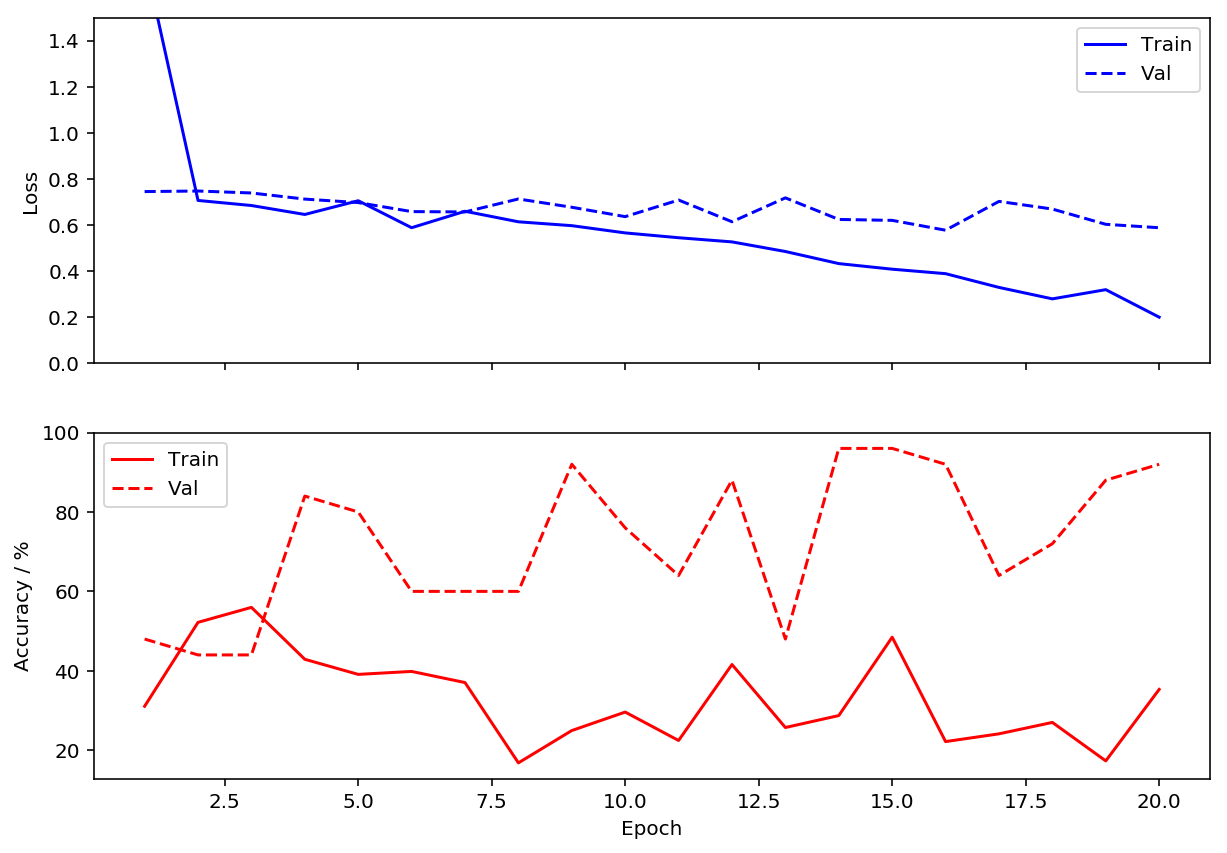

In [38]:
plot_learning_curve(trainer.history)

In [31]:
pred_val = trainer.predict_loader(val_loader, cuda_device=cuda_device)

100%|██████████| 45/45 [00:15<00:00,  2.92it/s]


In [32]:
pred_val.shape

torch.Size([45, 1])

In [33]:
val_labels.shape

(45, 1)

In [35]:
# Accuracy on val set.
np.mean(pred_val.cpu().data.numpy().round() == val_labels)

0.88888888888888884

In [59]:
import GPUtil

In [60]:
GPUtil.showUtilization()

 ID  GPU  MEM
--------------
  0   0%   3%


In [ ]:
# DEPRECATED: Manual training loop.
epochs = 40

for epoch in range(epochs):
    running_loss = 0
    
    for batch, (inputs, labels) in enumerate(train_loader):
        inputs, labels = Variable(inputs), Variable(labels)
        
        print('0')
        
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()
        
        optimizer.zero_grad()
        
        print('a')
        GPUtil.showUtilization()
        
        outputs = net(inputs)
        print('b')
        GPUtil.showUtilization()
        loss = loss_function(outputs, labels)
        print('c')
        GPUtil.showUtilization()
        loss.backward()
        print('d')
        GPUtil.showUtilization()
        optimizer.step()
        
        print('b')
        GPUtil.showUtilization()
        
        #del inputs, labels, outputs, loss
        
        print('c')
        GPUtil.showUtilization()
        
        running_loss += loss.data[0]
        n = 10
        if batch % n == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, batch + 1, running_loss / n))
            running_loss = 0.0

0
a
 ID  GPU  MEM
--------------
  0   0%  18%
b
 ID  GPU  MEM
--------------
  0  45%  18%
c
 ID  GPU  MEM
--------------
  0  73%  18%
d
 ID  GPU  MEM
--------------
  0  73%  18%
b
 ID  GPU  MEM
--------------
  0  84%  18%
c
 ID  GPU  MEM
--------------
  0  84%  18%
[1,     1] loss: 0.695
0
a
 ID  GPU  MEM
--------------
  0   6%  18%
b
 ID  GPU  MEM
--------------
  0   6%  18%
c
 ID  GPU  MEM
--------------
  0 100%  18%
d
 ID  GPU  MEM
--------------
  0 100%  18%
b
 ID  GPU  MEM
--------------
  0  56%  18%
c
 ID  GPU  MEM
--------------
  0  56%  18%
0
a
 ID  GPU  MEM
--------------
  0   0%  18%
b
 ID  GPU  MEM
--------------
  0   7%  18%
c
 ID  GPU  MEM
--------------
  0  83%  18%
d
 ID  GPU  MEM
--------------
  0  83%  18%
b
 ID  GPU  MEM
--------------
  0  74%  18%
c
 ID  GPU  MEM
--------------
  0  74%  18%
0
a
 ID  GPU  MEM
--------------
  0   0%  18%
b
 ID  GPU  MEM
--------------
  0   6%  18%
c
 ID  GPU  MEM
--------------
  0  82%  18%
d
 ID  GPU  MEM
--------

Process Process-2:
Traceback (most recent call last):
  File "/home/johannesr/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/home/johannesr/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/home/johannesr/anaconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 42, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "<ipython-input-51-40c3d9f7ed0e>", line 33, in __getitem__
    struct_arr = load_nifti(self.filenames[idx], mask=self.mask, remove_nan=self.remove_nan)
  File "utils.py", line 43, in load_nifti
    struct_arr = np.array(img.get_data())
  File "/home/johannesr/anaconda2/lib/python2.7/site-packages/nibabel/dataobj_images.py", line 202, in get_data
    data = np.asanyarray(self._dataobj)
  File "/home/johannesr/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py", line 583, in asanyarray
   

# Apply interpretation methods

In [27]:
# TODO: These are adapted from above in order to deal with binary output instead of softmax. Generalize this.
# TODO: Maybe add cuda support.
# TODO: Document.

def sensitivity_analysis(model, image_tensor, target=None, postprocess='abs', output_mode=None):
    # image_tensor can be a pytorch tensor or anything that can be converted to a pytorch tensor (e.g. numpy, list)
    
    if output_mode not in [None, 'binary', 'categorical']:
        raise ValueError("output_mode must be None, 'binary' or 'categorical'")
    if postprocess not in [None, 'abs', 'square']:
        raise ValueError("postprocess must be None, 'abs' or 'sqaure'")
    
    # Forward pass.
    image_tensor = torch.Tensor(image_tensor)  # convert numpy or list to tensor
    X = Variable(image_tensor[None], requires_grad=True)  # add dimension to simulate batch
    model.eval()
    output = model(X)
    
    # Backward pass.
    model.zero_grad()
    if output_mode is None:
        output_mode = 'binary' if output.size(1) == 1 else 'categorical'
    if output_mode == 'binary':  # binary output
        # TODO: Does it make sense to always use one here as the output gradient? 
        #       (This is similar to using one-hot below.)
        print('Image was classified as:', output.data.numpy()[0, 0].round())
        #print(output)
        output.backward(gradient=torch.ones(output.size()))
    elif output_mode == 'categorical':  # categorical output
        output_class = output.max(1)[1].data.numpy()[0]
        print('Image was classified as:', output_class)
        # TODO: Check if setting to one hot makes sense here.
        one_hot_output = torch.zeros(output.size())
        if target is None:
            one_hot_output[0, output_class] = 1
        else:
            one_hot_output[0, target] = 1
        output.backward(gradient=one_hot_output)
        
    relevance_map = X.grad.data[0].numpy()
    
    # Postprocess the relevance map.
    if postprocess == 'abs':  # as in Simonyan et al. (2013)
        return np.abs(relevance_map)
    elif postprocess == 'square':  # as in Montavon et al. (2018)
        return relevance_map**2
    elif postprocess is None:
        return relevance_map
        
        
def guided_backprop(model, image_tensor, target=None, postprocess='abs', output_mode=None):
    
    def relu_hook_function(module, grad_in, grad_out):
        """
        If there is a negative gradient, change it to zero.
        """
        if isinstance(module, nn.ELU):
            return (torch.clamp(grad_in[0], min=0.0),)
        
    hook_handles = []
    
    try:
        # Loop through layers, hook up ReLUs with relu_hook_function, store handles to hooks.
        #for pos, module in model.features._modules.items():
        for module in model.children():
            if isinstance(module, nn.ELU):
                # TODO: Add a warning if no activation layers have been hooked, so that the user does not forget to invoke the activation via nn.ELU instead of F.elu.
                print('Registered hook for layer:', module)
                hook_handle = module.register_backward_hook(relu_hook_function)
                hook_handles.append(hook_handle)

        # Calculate backprop with modified ReLUs.
        relevance_map = sensitivity_analysis(model, image_tensor, target=target, postprocess=postprocess, output_mode=output_mode)
        
    finally:
        # Remove hooks from model.
        # The finally clause re-raises any possible exceptions.
        print('Removing {} hook(s)'.format(len(hook_handles)))
        for hook_handle in hook_handles:
            hook_handle.remove()
            del hook_handle
        
    return relevance_map

In [ ]:
net = net.cpu()

0.0 764.588567782 None None


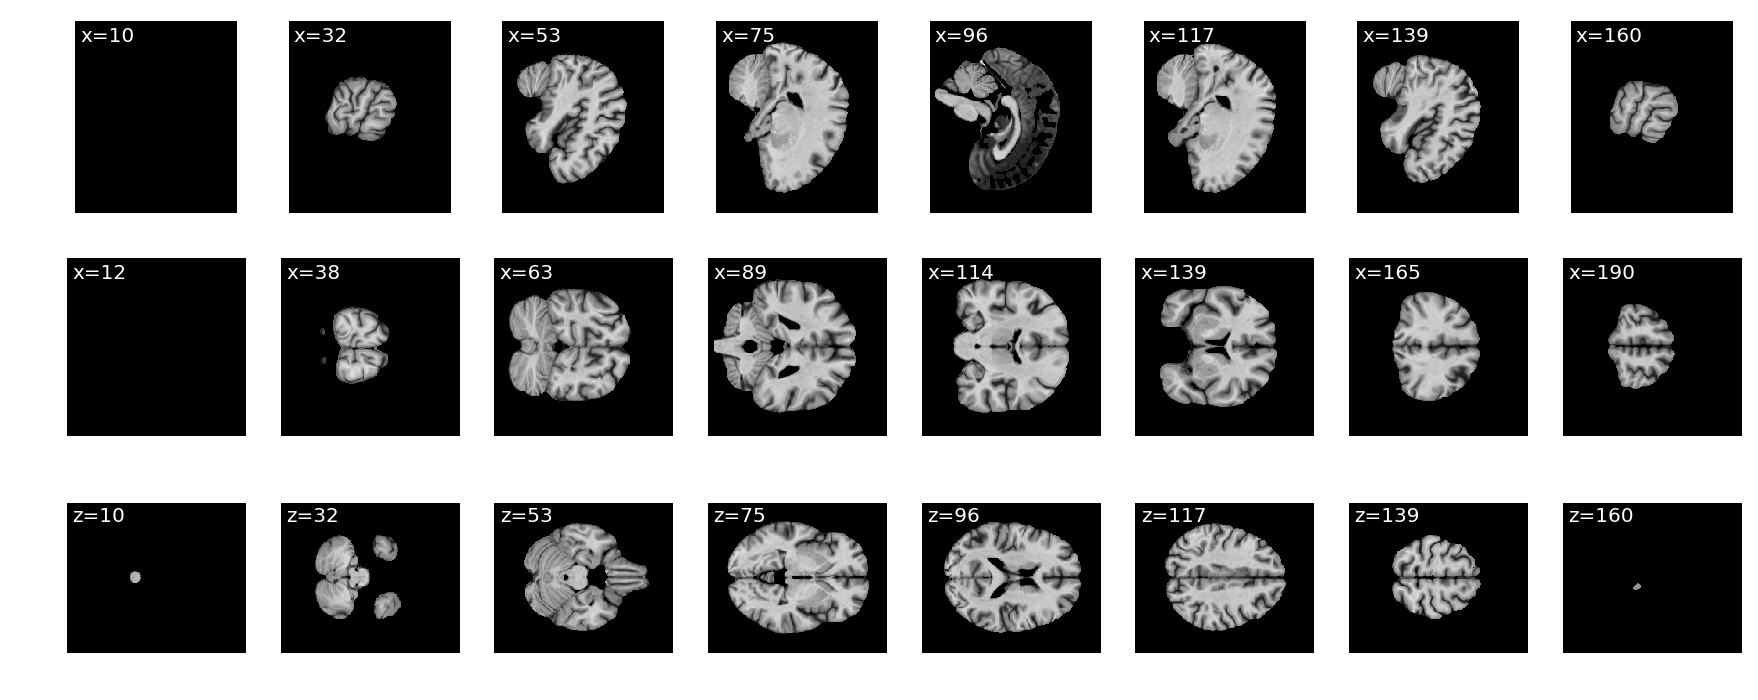

In [264]:
which = 0

raw_image = val_dataset.get_raw_image(which)#val_dataset[0][0]
plot_slices(raw_image)

In [401]:
relevance_map = sensitivity_analysis(net, val_dataset[which][0])

Image was classified as: 0.0


0.0 764.588567782 0.0 3.96140902012e-05


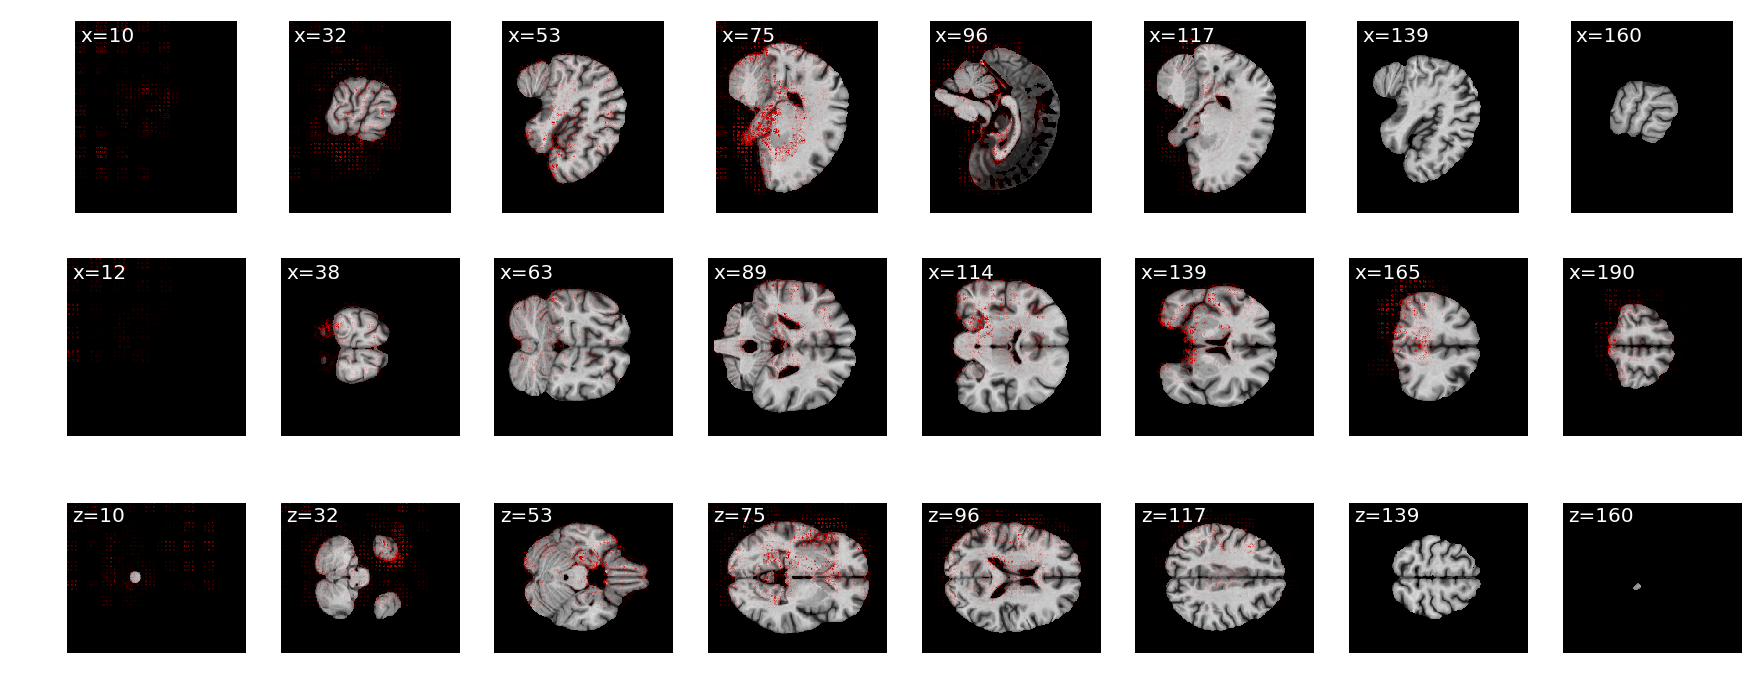

In [402]:
# TODO: Plot unnormalized base image.
plot_slices(raw_image, overlay=relevance_map[0], overlay_vmax=np.percentile(relevance_map, 99.9))

In [267]:
relevance_map_guided = guided_backprop(net, val_dataset[which][0])

Registered hook for layer: ELU(alpha=1.0)
Image was classified as: 0.0
Removing 1 hook(s)


0.0 764.588567782 0.0 1.77672609061e-05


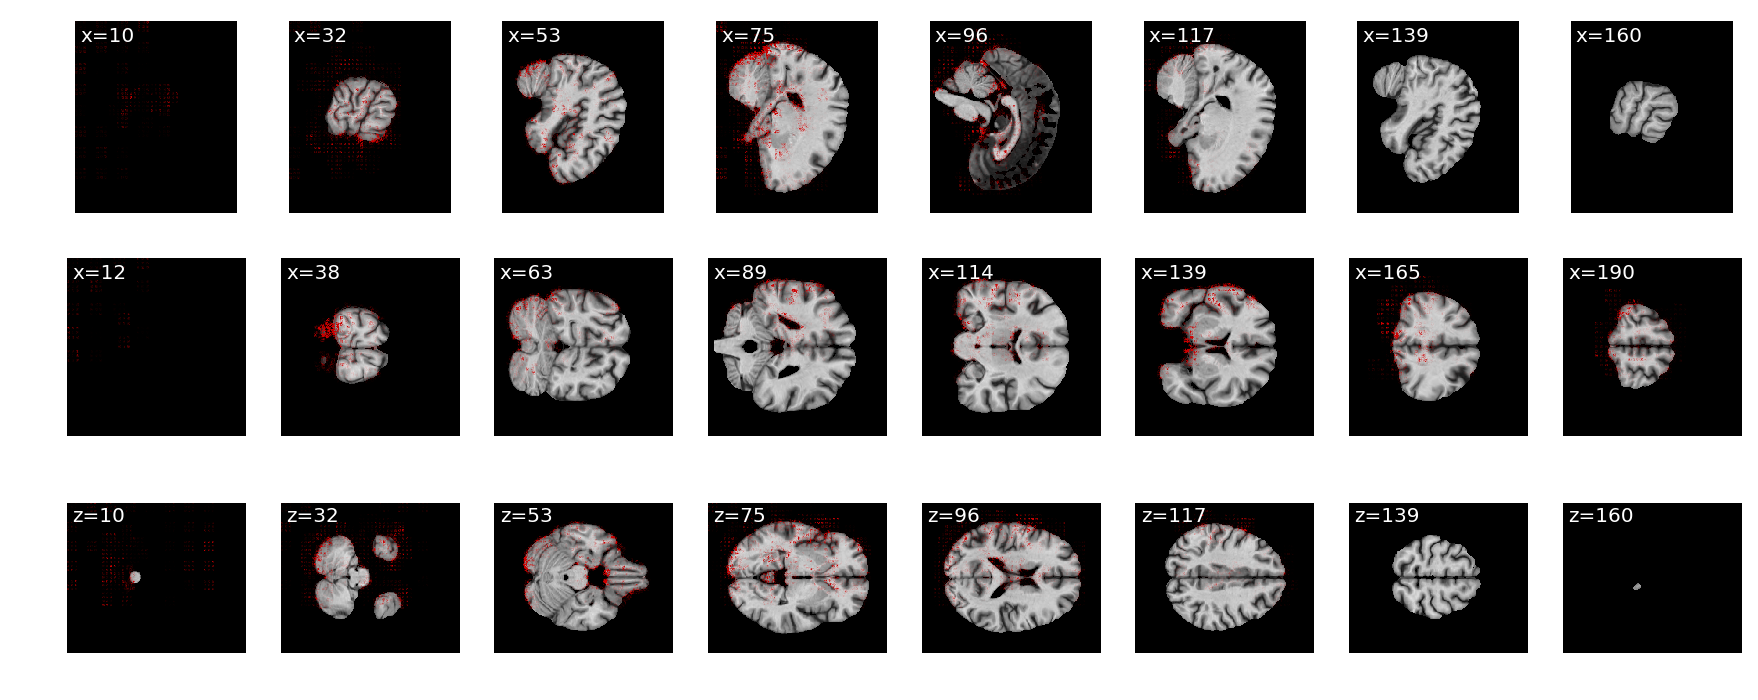

In [269]:
# TODO: Why are some values from the overlay so large? Why do I have to use percentile to see something reasonable here?
plot_slices(raw_image, overlay=relevance_map_guided[0], overlay_vmax=np.percentile(relevance_map_guided, 99.9))

(0, 100000)

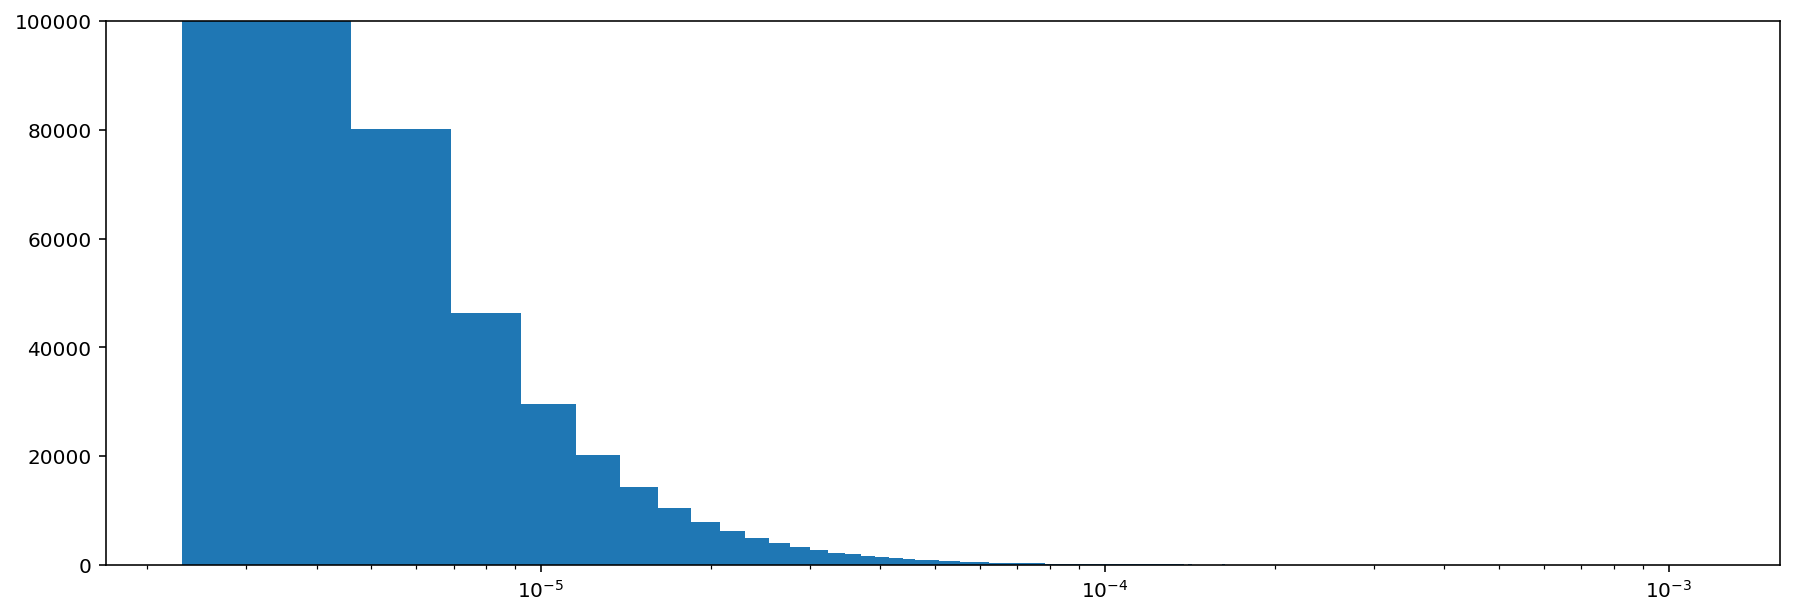

In [180]:
plt.figure(figsize=(15, 5))
plt.hist(relevance_map_guided.flatten(), 500);
plt.xscale('log')
plt.ylim(0, 100000)

In [279]:
from IPython.display import HTML

anim = animate_slices(raw_image, overlay=relevance_map_guided[0], overlay_vmax=np.percentile(relevance_map_guided, 99.9), axis=2, reverse_direction=True, interval=150)
plt.close()  # suppress plot output

In [280]:
plt.rcParams['animation.ffmpeg_path'] = u'/home/johannesr/ffmpeg-3.4.1-64bit-static/ffmpeg'    

In [281]:
HTML(anim.to_html5_video())

In [ ]:
# TODO: This gives an error with ffmpeg. Fix it or use another writer via writer=...
#anim.save('data/animated_slices.gif')

# Convert keras model to pytorch
This was done as a first test to convert the existing keras model for ADNI (trained by Fabian, see [this notebook](https://github.com/derEitel/nn-experiments/blob/master/AD_NC_48_48.ipynb)) to pytorch. It is not used any more, but kept here for convenience.

In [ ]:
import keras

In [ ]:
model_filename = os.path.join(FOLDER, 'models/model_121217_1.h5')
model = keras.models.load_model(model_filename)

In [ ]:
class ClassificationModel3D(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.Conv_1 = nn.Conv3d(1, 64, 3)
        self.Conv_2 = nn.Conv3d(64, 64, 3)
        self.Conv_3 = nn.Conv3d(64, 64, 3)
        self.Conv_4 = nn.Conv3d(64, 64, 3)
        self.dense_1 = nn.Linear(128, 1)
        self.elu = nn.ELU()
        
    def forward(self, x):
        x = self.elu(self.Conv_1(x))  # TODO: Probably need relu for guided backprop!
        x = F.max_pool3d(x, 3)
        #plot_slices(x[0])
        x = self.elu(self.Conv_2(x))
        x = F.max_pool3d(x, 3)
        x = self.elu(self.Conv_3(x))
        x = self.elu(self.Conv_4(x))
        x = F.max_pool3d(x, 3)
        
        # The permute operation converts the tensor from channels_first to channels_last format.
        # This is required to transfer a keras model that uses channels_last (pytorch uses channels_first by default).
        # Otherwise, the Flatten layer in keras and the view operation here output different values.
        # Remove this if the original keras network uses channels_first.
        x = x.permute(0, 2, 3, 4, 1).contiguous()
        
        x = x.view(x.size(0), -1)
        x = F.sigmoid(self.dense_1(x))
        return x
    
pytorch_model = ClassificationModel3D()

In [ ]:
list(pytorch_model.children())

In [ ]:
from nn_transfer import transfer

In [ ]:
transfer.keras_to_pytorch(model, pytorch_model)